### high resolution view of the transition disk for Figure 3b

#### 3/21/23  jpw

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from radio_beam import Beam
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from matplotlib.patches import Ellipse
from astropy.visualization import (MinMaxInterval, SqrtStretch, SinhStretch, AsinhStretch, LogStretch, ImageNormalize)
from matplotlib.patches import Ellipse
%matplotlib inline

In [53]:
path = '/Volumes/JPW2T/OphIRS43/ALMA/SBLB/'
filename = "OphIRS43_SBLB_continuum_robust_-0.5.pbcor.tt0.fits"

In [54]:
hdu = fits.open(path+filename)[0]
im = hdu.data.squeeze()
hd = hdu.header

In [55]:
b = Beam.from_fits_header(hd)
print(b)
bmaj = hd['BMAJ']*3600    # arcsec
bmin = hd['BMIN']*3600    # arcsec
bpa = hd['BPA']           # degrees

Beam: BMAJ=0.056282691657528 arcsec BMIN=0.03857117518782 arcsec BPA=69.47651672363 deg


In [56]:
# conversion to brightness temperature
omega = np.pi * bmaj * bmin / (4 * np.log(2))        # arcsec**2
omega *= (np.pi/180/3600)**2                         # steradians
wl = 0.128                                           # wavelength in cm (nu = 234 GHz)
Tb  = wl**2 * 1e-23 * im / (2 * 1.36e-16 * omega)    # cgs

In [57]:
vla1 = SkyCoord('16h27m26.906s', '-24d40m50.82s', frame='icrs')
vla2 = SkyCoord('16h27m26.911s', '-24d40m51.40s', frame='icrs')
dra, ddec = vla1.spherical_offsets_to(vla2)
x_vla2 = dra.to(u.arcsec).value
y_vla2 = ddec.to(u.arcsec).value

td = SkyCoord('16h27m26.602s', '-24d40m45.70s', frame='icrs')
dra, ddec = vla1.spherical_offsets_to(td)
x_td = dra.to(u.arcsec).value
y_td = ddec.to(u.arcsec).value

In [75]:
def plot_cont(im, hd, vmin=None, vmax=None, extent=None, pdf=None):
    ra  = hd['CRVAL1'] + (1+np.arange(hd['NAXIS1'])-hd['CRPIX1'])*hd['CDELT1']    # degrees
    dec = hd['CRVAL2'] + (1+np.arange(hd['NAXIS2'])-hd['CRPIX2'])*hd['CDELT2']
    dra = (ra - vla1.ra.value) * 3600
    ddec = (dec - vla1.dec.value) * 3600
    
    if extent == None:
        extent = [dra[0], dra[-1], ddec[0], ddec[-1]]
        imin = 0
        imax = hd['NAXIS1']-1
        jmin = 0
        jmax = hd['NAXIS2']-1
    else:
        extent = extent
        imin = np.argmin(np.abs(dra-extent[0]))
        imax = np.argmin(np.abs(dra-extent[1]))
        jmin = np.argmin(np.abs(ddec-extent[2]))
        jmax = np.argmin(np.abs(ddec-extent[3]))
    asp = np.abs((extent[3] - extent[2]) / (extent[1] - extent[0]))
    
    #print(imin,imax, jmin,jmax)
    #print(extent)

    fig = plt.figure(figsize=(10,9))
    ax = plt.subplot(111)
    
    # image
    imcrop = im[jmin:jmax, imin:imax]
    print(imcrop.min(), imcrop.max())
    norm1 = ImageNormalize(imcrop, vmin=vmin, vmax=vmax, stretch=AsinhStretch(0.3))
    p = ax.imshow(imcrop, extent=extent, origin='lower', norm=norm1, cmap='viridis')
    
    # labels
    ax.text(-4.03, 5.23, "GY263", color='white', ha='right', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlabel(r"$\Delta\alpha\ ('')$", fontsize=14)
    ax.set_ylabel(r"$\Delta\delta\ ('')$", fontsize=14)

    # beam
    xb = -3.8
    yb = 4.8
    beam = Ellipse((xb, yb), hd['BMAJ']*3600, hd['BMIN']*3600, angle=90-hd['BPA'], edgecolor='black', facecolor='lightgray', linewidth=1)
    ax.add_patch(beam)
    
    # scale bar
    d = 137.3   # pc
    s = 10.0   # scale bar size in au
    t = s/d     # arcsec
    xs = -4.5
    ys = yb
    ax.plot([xs-0.5*t, xs+0.5*t], [ys, ys], 'w-', lw=2)
    ax.plot([xs-0.5*t, xs-0.5*t], [ys-0.05*t, ys+0.05*t], 'w-', lw=2)
    ax.plot([xs+0.5*t, xs+0.5*t], [ys-0.05*t, ys+0.05*t], 'w-', lw=2)
    ax.text(xs, ys+0.12*t, '10 au', color='white', ha='center', fontsize=12)
    
    # intensity scale
    cb = plt.colorbar(p, orientation="vertical", fraction=0.078, pad=0.01)
    cb.set_label(r'Brightness Temperature (K)', rotation=90, labelpad=6, fontsize=14)

    fig.tight_layout()
    try:
        plt.savefig(pdf)
        print("Image saved as "+pdf)
    except:
        pass

-1.4512215 7.5629997
Image saved as fig3b.pdf


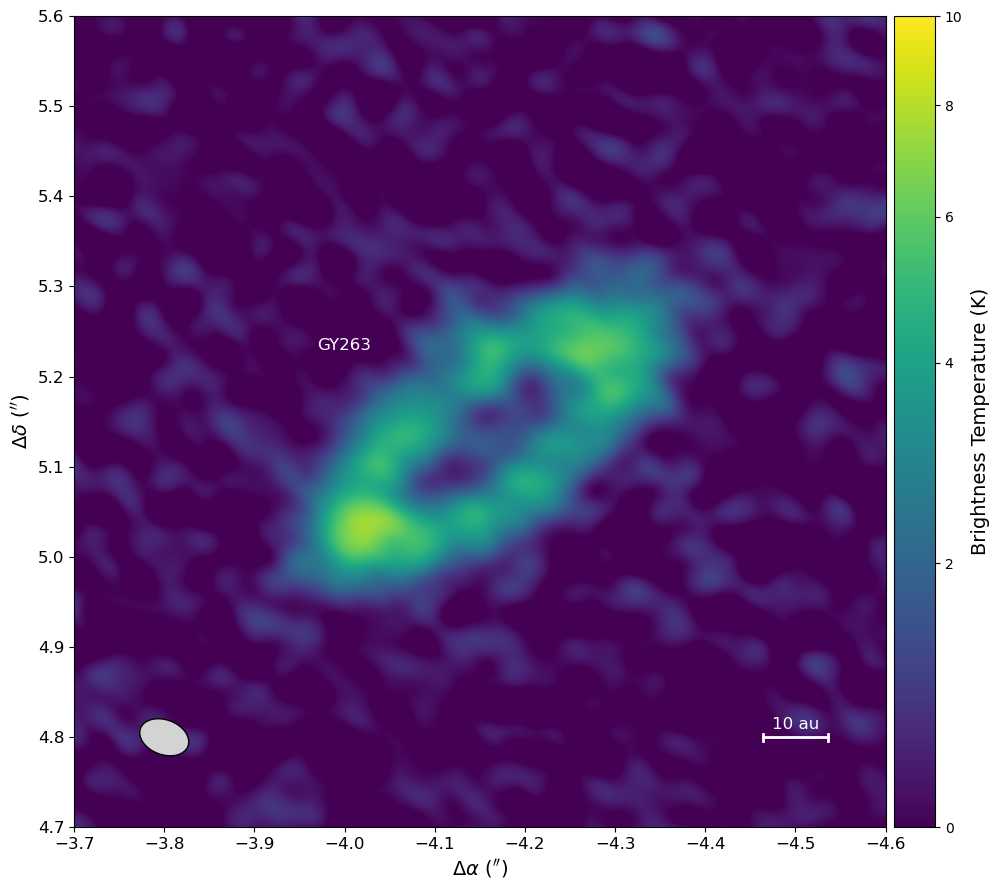

In [76]:
plot_cont(Tb, hd, extent=[-3.7, -4.6, 4.7, 5.6], vmin=0, vmax=10, pdf='fig3b.pdf')